#define model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from data_mgmt import DAO
import matplotlib.pyplot as plt

In [2]:
def model_define(features, drop_rate):

    tf.summary.image("laser_inst", features)

    model = models.Sequential()

    model.add(layers.Conv2D(
        32, (11,1), padding="same", input_shape=(720,1,1),
        name="conv_1" ))
    model.add(layers.Conv2D(
        64, kernel_size=(5,1), padding="same",
        name="conv_2" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_1" ))
    model.add(layers.Conv2D(
        256, kernel_size=(5,1), padding="same",
        name="conv_3" ))
    model.add(layers.MaxPooling2D(
        (2,1), strides=2, padding="same",
        name="pool_2" ))

    model.add(layers.Flatten())

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1024, activation="relu", name="dense_1"))

    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(128, activation="relu", name="dense_2"))

    model.add(layers.Dense(3, name="dense_3"))

    return model

In [3]:
filename="laser_log/laser_log.csv"

data = DAO(filename)

data.read()
data.divide_data(0.25)

In [4]:
model_cnn = model_define(data.features, 0.5)

2022-03-16 11:37:33.198913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 11:37:33.199369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 11:37:33.199489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-16 11:37:33.199596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-16 11:37:33.199699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
model_cnn.compile(optimizer = "adam",
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mean_absolute_error'])

In [7]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 720, 1, 32)        384       
                                                                 
 conv_2 (Conv2D)             (None, 720, 1, 64)        10304     
                                                                 
 pool_1 (MaxPooling2D)       (None, 360, 1, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 360, 1, 256)       82176     
                                                                 
 pool_2 (MaxPooling2D)       (None, 180, 1, 256)       0         
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dropout (Dropout)           (None, 46080)             0

In [8]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3,1,1])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3,1,1])

In [9]:
history = model_cnn.fit(data.TR_features, data.TR_targets, epochs=10, validation_data=(data.TS_features, data.TS_targets))


Epoch 1/10


2022-03-16 11:38:27.519116: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188743680 exceeds 10% of free system memory.
2022-03-16 11:38:27.555388: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188743680 exceeds 10% of free system memory.


22/22 [==============================] - 13s 545ms/step - loss: 287.5292 - mean_absolute_error: 8.2009 - val_loss: 24.9995 - val_mean_absolute_error: 4.3648
Epoch 2/10
22/22 [==============================] - 12s 531ms/step - loss: 22.8684 - mean_absolute_error: 4.0060 - val_loss: 20.9609 - val_mean_absolute_error: 4.0197
Epoch 3/10
22/22 [==============================] - 11s 519ms/step - loss: 20.6049 - mean_absolute_error: 3.8609 - val_loss: 20.8644 - val_mean_absolute_error: 4.0087
Epoch 4/10
22/22 [==============================] - 11s 509ms/step - loss: 20.1137 - mean_absolute_error: 3.8187 - val_loss: 20.6927 - val_mean_absolute_error: 3.9844
Epoch 5/10
22/22 [==============================] - 11s 507ms/step - loss: 19.8954 - mean_absolute_error: 3.8118 - val_loss: 20.5633 - val_mean_absolute_error: 3.9695
Epoch 6/10
22/22 [==============================] - 11s 494ms/step - loss: 19.9757 - mean_absolute_error: 3.8219 - val_loss: 20.7574 - val_mean_absolute_error: 4.0019
Epoch 7/

8/8 - 1s - loss: 19.9954 - mean_absolute_error: 3.8494 - 980ms/epoch - 122ms/step


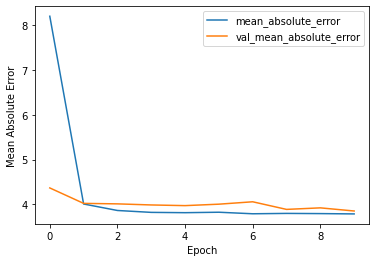

In [15]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model_cnn.evaluate(data.TS_features,  data.TS_targets, verbose=2)
